# Transfer Learning Template 
### Author: Armando Ordorica

### Helper Functions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz

# Define a function to unnormalize and show the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
print("start")

start


### Setting Device to Use Apple M1 Max GPU

In [2]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU")


Using MPS device


### 1. Load the CIFAR-10 dataset

In [3]:

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)


train_size = int(0.8 * len(trainset))  # 80% of the dataset
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)



Files already downloaded and verified


In [4]:


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


### 2. Load the pre-trained model and modify the final layer

In [5]:
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)  # Move model to the chosen device

### 3. Define a loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCHS =3

### 4. Fine-tune the model


In [7]:
# 4. Fine-tune the model
loss_values = []
val_loss_values = []


for epoch in range(NUM_EPOCHS):  # Change to 1 epoch for quick test
    print(epoch)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 500 == 499:  # Print loss every 500 mini-batches
            print('[%d, %5d] training loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            loss_values.append(running_loss / 500)
            running_loss = 0.0
            
        
        if i == 999:  # Limit to 1000 mini-batches for quick test
            break

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(valloader)
        val_loss_values.append(avg_val_loss)
        print('Validation loss after epoch %d: %.3f' % (epoch + 1, avg_val_loss))

print('Finished Fine-tuning')

0
[1,   500] training loss: 1.492
[1,  1000] training loss: 1.183
Validation loss after epoch 1: 1.006
1
[2,   500] training loss: 1.459
[2,  1000] training loss: 0.961
Validation loss after epoch 2: 0.779
2
[3,   500] training loss: 0.850
[3,  1000] training loss: 0.808
Validation loss after epoch 3: 0.641
Finished Fine-tuning


#### Plotting loss values

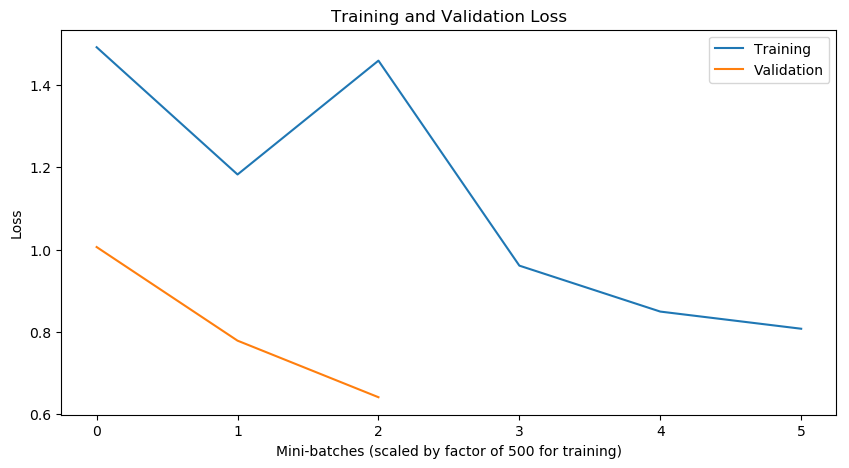

In [8]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(loss_values,label="Training")
plt.plot(val_loss_values,label="Validation")
plt.xlabel("Mini-batches (scaled by factor of 500 for training)")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
loss_values, val_loss_values

([1.4919496235251426,
  1.1826878289729357,
  1.4593548646569252,
  0.9611744441501796,
  0.8495551942177116,
  0.8078526816725498],
 [1.0064018338560157, 0.7788738897442264, 0.6414304267646744])

In [10]:
# Define the EST timezone
est = pytz.timezone('US/Eastern')

# Get the current time in UTC and convert to EST
current_time_est = datetime.datetime.now(pytz.utc).astimezone(est)

print(current_time_est.strftime('%Y-%m-%d %H:%M:%S %Z%z'))
timestamp_file = current_time_est.strftime('%Y_%m_%d_%H_%M_%S')
timestamp_file

2023-10-21 14:01:41 EDT-0400


'2023_10_21_14_01_41'

### 5. Test the model on test data

In [11]:
num_batches = len(testloader)
batch_size = testloader.batch_size
total_test_images = num_batches * batch_size
total_test_images = len(testloader.dataset)


print(num_batches, batch_size, total_test_images)

2500 4 10000


In [12]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

torch.save(model, f'entire_fine_tuned_resnet18_{timestamp_file}.pth')


Accuracy of the network on the 10000 test images: 78 %


### 5. Load the saved model


In [13]:
model = torch.load(f'entire_fine_tuned_resnet18_{timestamp_file}.pth')
model = model.to(device)

#### 5.1 Set the model to evaluation mode

In [14]:
model.eval()  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


### 6. Test the model on test data

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %


### 6.1 Shuffling the Test Loader so that every time I sample I get different Images

In [16]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True)

Files already downloaded and verified


### 7. Visualize true vs predicted labels on random samples

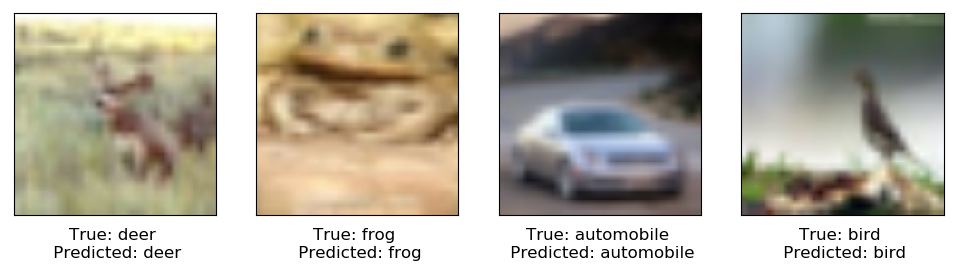

In [17]:


# Define the classes of CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


# Get a random sample from the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels for the sample
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)


# Plot the images along with true and predicted labels
fig = plt.figure(figsize=(12, 6))
for idx in range(4):  # Assuming a batch size of 4
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx].item()]} \n Predicted: {classes[predicted[idx].item()]}", y=-0.25)

plt.show()

In [18]:
# ls

In [19]:
# !jupyter nbconvert --to script transfer_learning_hello_world.ipynb